In [22]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
from tensorflow.keras.optimizers import Adamax


# Load Data

In [23]:
training_dir = 'tumor_data/Training'
testing_dir = 'tumor_data/Testing'

In [24]:
# Step 1: Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Rescale pixel values to [0, 1]
    #shear_range=0.2,         # Random shear
    #zoom_range=0.2,          # Random zoom
    #horizontal_flip=True,     # Random horizontal flip
    validation_split=0.2)     # Use 20% of training data for validation if no separate validation directory

test_datagen = ImageDataGenerator(rescale=1./255)

# Step 2: Load Training and Validation Data
train_generator = train_datagen.flow_from_directory(
    training_dir,
    # color_mode='grayscale',
    target_size=(128, 128),      # Resize images to 128x128
    batch_size=32,
    class_mode='categorical',    # Since we have 4 classes
    subset='training')           # Use 'training' subset (80% of data)

validation_generator = train_datagen.flow_from_directory(
    training_dir,
    # color_mode='grayscale',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation')         # Use 'validation' subset (20% of data)

# Step 3: Load Test Data
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    # color_mode='grayscale',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [25]:
images, labels = next(train_generator)
print("image shape", images[0].shape)

image shape (128, 128, 3)


In [26]:
def get_next_filename():
    results_dir = "results"
    if not os.path.exists(results_dir):
            os.makedirs(results_dir)

    # Find the next available filename
    existing_files = [f for f in os.listdir(results_dir) if f.startswith("cnn_confusion_matrix")]
    if existing_files:
        existing_numbers = [int(f.split("cnn_confusion_matrix")[1].split(".png")[0]) for f in existing_files]
        next_number = max(existing_numbers) + 1
    else:
        next_number = 1
    filename = os.path.join(results_dir, f"cnn_confusion_matrix{next_number}")
    return filename, next_number

filename, next_number = get_next_filename()
logfile = "results/cnn_log.txt"
cfm = f"{filename}.png"
print(logfile)
print(cfm)

with open(logfile, "a") as file:
     a = "*"*80
     b = f"CNN - {next_number}"
     file.write(f"\n\n{a}\n{b}\n")

results/cnn_log.txt
results/cnn_confusion_matrix7.png


# Visualize Data

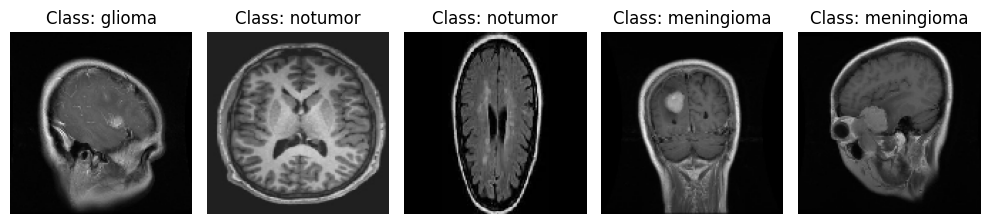

In [27]:
images, labels = next(train_generator)
class_labels = list(train_generator.class_indices.keys())
num_images_to_display = 5
plt.figure(figsize=(10, 10))

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {class_labels[np.argmax(labels[i])]}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

# CNN Model

In [45]:
# model = Sequential([
#     # First Convolutional Block
#     Conv2D(64, kernel_size=(3, 3), groups=1, input_shape=(128, 128, 3)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.1),
    
#     # Second Convolutional Block
#     Conv2D(128, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.1),

#     # Third Convolutional Block
#     Conv2D(256, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.1),

#     # Flatten and Fully Connected Layers
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dense(4, activation='softmax')  # Output layer for 4 classes
# ])
model = Sequential([
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(128,128,3), padding="SAME"),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding="SAME"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, kernel_size=(3,3), activation='relu', padding="SAME"),
    Conv2D(128, kernel_size=(3,3), activation='relu', padding="SAME"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, kernel_size=(3,3), activation='relu', padding="SAME"),
    Conv2D(256, kernel_size=(3,3), activation='relu', padding="SAME"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.15),
    
    Conv2D(128, kernel_size=(3,3), activation='relu', padding="SAME"),
    Conv2D(128, kernel_size=(3,3), activation='relu', padding="SAME"),
    MaxPooling2D((2,2)),
    
    Conv2D(64, kernel_size=(3,3), activation='relu', padding="SAME"),
    Conv2D(64, kernel_size=(3,3), activation='relu', padding="SAME"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(4, activation='softmax')
])

In [46]:
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
with open(logfile, "a") as f:
    model.summary(print_fn=lambda x: f.write(x + "\n"))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_149 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 conv2d_150 (Conv2D)         (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_151 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 conv2d_152 (Conv2D)         (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 32, 32, 128)       0         
 ng2D)                                               

In [48]:
batch_size = 32
epochs = 10

history = model.fit(
    train_generator,  # training data
    validation_data=validation_generator,  # validation data
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
143/143 [==============================] - 1270s 9s/step - loss: 0.4527 - accuracy: 0.8237 - val_loss: 0.8037 - val_accuracy: 0.7528
Epoch 2/10
143/143 [==============================] - 1180s 8s/step - loss: 0.4020 - accuracy: 0.8473 - val_loss: 0.7677 - val_accuracy: 0.7195
Epoch 3/10
143/143 [==============================] - 1185s 8s/step - loss: 0.3132 - accuracy: 0.8836 - val_loss: 0.5875 - val_accuracy: 0.7932
Epoch 4/10
143/143 [==============================] - 1192s 8s/step - loss: 0.2712 - accuracy: 0.8989 - val_loss: 0.6208 - val_accuracy: 0.7993
Epoch 5/10
143/143 [==============================] - 1184s 8s/step - loss: 0.2097 - accuracy: 0.9234 - val_loss: 0.6979 - val_accuracy: 0.8054
Epoch 6/10
143/143 [==============================] - 1188s 8s/step - loss: 0.1886 - accuracy: 0.9293 - val_loss: 0.5837 - val_accuracy: 0.8291
Epoch 7/10
143/143 [==============================] - 1182s 8s/step - loss: 0.1515 - accuracy: 0.9409 - val_loss: 0.6843 - val_accuracy:

# Result/Analysis

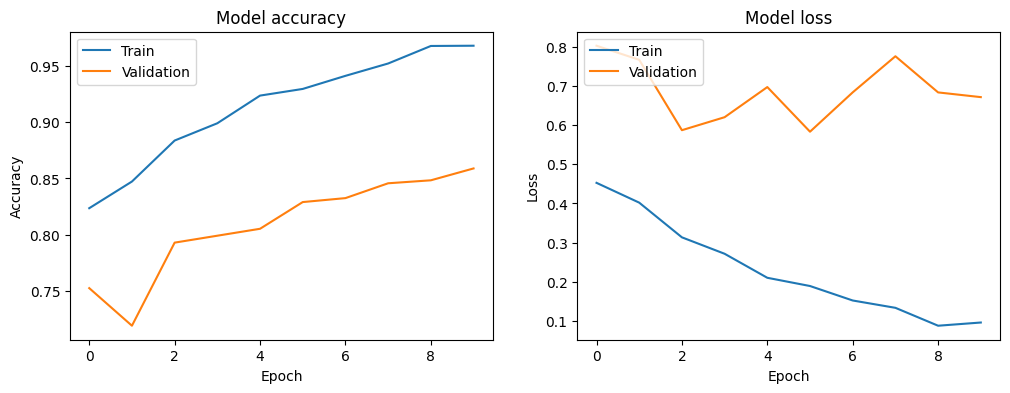

In [49]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
plot_history(history)


/var/folders/x0/nbf97btn32gbzmgh9wzzbcd40000gn/T/ipykernel_29590/1266696977.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


Preds	 [[8.0815425e-09 4.8702885e-04 9.9951285e-01 7.6920630e-11]
 [2.7869539e-03 5.3440360e-03 6.7921224e-05 9.9180096e-01]
 [2.2427517e-01 7.7547288e-01 1.8003359e-04 7.1982911e-05]
 [1.5543449e-06 2.3431385e-05 9.9997133e-01 3.6327576e-06]
 [5.1300990e-09 3.2818139e-07 9.9999958e-01 1.7059681e-09]]
True	 [0 0 0 0 0]
results/cnn_confusion_matrix7


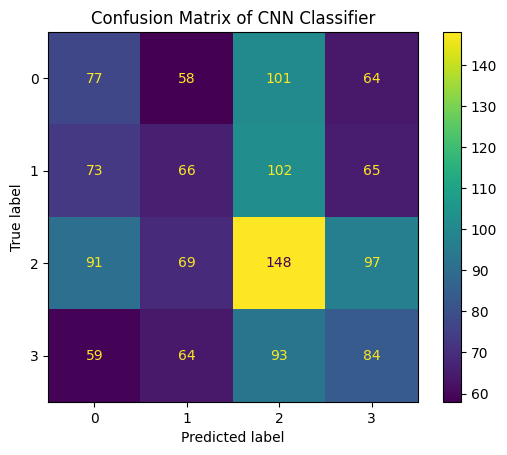

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions for the test set
y_pred = model.predict_generator(test_generator)
assert len(y_pred) == len(test_generator.classes)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_generator.classes          # True class labels
print("Preds\t", y_pred[:5])
print("True\t", y_true[:5])

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix of CNN Classifier")
filename, number = get_next_filename()
print(filename)
plt.savefig(filename)
plt.show()
plt.close()


In [51]:
test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}